## Comparison of Numerical Integration Schemes (Adaptive Runge-Kutta)
### Thomas Bieniewicz

Problem 1 of Homework 1 utilizes two ODE Numerical Integration Schemes are used: 1st Order Forward Euler and 4th Order Runge-Kutta. 

These schemes appeared to work well enough for basic applications at a first glance but begged the question: 
What are the advantages and disadvantages of using other ODE Numerical Integrators with advanced features, such as an adaptie time step for calculations? 

Importance of ODE Numerical Solvers/Integeators: 

1) In practice we often plan in discrete time

2) When applying control methods in real world settings, digital controllers on computers are almost always used, which require discrete time and thus continuous time dynamics must be discretized for implementation

3) There are very few cases where discretizing a continuous time system can be done analytically, even fewer when strictly considering "real world settings" where it can be difficult to make assumptions about linearity and other simplifications to a problem. 

Adaptive Runge-Kutta Method: 

Concept
- Before the integration an initial time step value, min value for change in x, max allowed relative difference in half step and full step, and min allowed relative difference in full step and double step

- Every time the next value $x_k+1$ is calculated a full step (same as regular Runge-Kutta), a half step, and double step are calculated. This is like moving in the same "direction" as with non-adaptive Runge-Kutta but at only half or double the "distance"

- Then, we compare the difference in calcualted $x_k+1$ between the full step and half step and full step and double step to determine if we should take a larger or shorter time step proceeding from the current time step. 

Advantages
- Potential savings in computation by specifying limits on the relative value of a full, half, and double step and defining the time step based upon those specifications as a variable. This allows the algorithm to take much larger steps when the dynamics are smooth and don't require as high of a degree of resolution to capture its shape (function changing slowly with time); and take much smaller steps when a high degree of resiultion is required (function is changing a lot with very small changes in time)

    In effect, the algorithm records more data points when they are needed to determine the behavior of the function and takes less data points to save on computation not needed to determine the behavior of the function. This becomes extrmely valuable when requiring a high degree of accuracy for simulations of long periods of time.

- No new math is needed to apply this method; only new code to generate an actively changing time step (dt). The ODE Numerical Integrator should work with any system linear, nonlinear, or time varying by changing the continuous dynamics function. 

Disadvantages
- Because the dt (time step) is variable, the number of values in a contol sequence and their corresponding times are also variable, which makes defining an input sequence for u is impossible to do before the integration. This is not an issue if the control input u is constant for interval the numerical integral is evaluated over. 

- Instead, if an analytic function for the input u exists, a solution would be to slightly change the code so that the analytic function for u can be evaluated at each time t and then its output array could be fed as an argument to the dynamics functions. 

In [1]:
import abc
from typing import Callable
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import functools
import cvxpy as cvx

For this example, the same code from HW1 Problem 1 (dynamic_unicycle_ode) is used to define the continuous time dynamics for easy comparison, and a slightly modified version of the runge_kutta_integrator function still utilizing the same 4th order Runge-Kutta scheme from that same problem is also used.
- the control input u is held constant
- the initial state $x(0)$ = 0
- system is simulated over 5 second duration (t = 0 to t = 5)
- results are plotted with the individual data points marked

In [2]:
# Step 1 - define Continuous Dynamics (same as HW1-P1)
def dynamic_unicycle_ode(x, u, t):         
    x, y, theta, v = x      # decompose state variables and control inputs 
    w, a = u
    # still need to pass in t, its just not used because time invariant

    xdot = v * jnp.cos(theta)   # nonlinear state equations
    ydot = v * jnp.sin(theta)
    thetadot = w
    vdot = a

    state_dot = jnp.array([xdot,ydot,thetadot,vdot])      # derivative of state variables --> xdot = f(x,u,t)
    return state_dot

# Step 2 - define RK4 integrator (converts continuous dyunamics to discrete dynamics)
def adaptive_runge_kutta_integrator(continuous_dynamics, dt, x, u, t):
        f1 = continuous_dynamics(x,u,t)                            # still need to pass in t, not used in time invariant
        f2 = continuous_dynamics(x + (dt/2)*f1, u, t + (dt/2))
        f3 = continuous_dynamics(x + (dt/2)*f2, u, t + (dt/2))
        f4 = continuous_dynamics(x + dt*f3, u, t + dt)  

        x_full = x + (dt/6) * (f1 + 2*f2 + 2*f3 + f4)       # full step
        
        x_double = x + (dt/3) * (f1 + 2*f2 + 2*f3 + f4)     # double step
        x_half = x + (dt/12) * (f1 + 2*f2 + 2*f3 + f4)      # half step

        return x_full, x_half, x_double                     # returns result of all step sizes

# Step 3 - define function to check differences in step magnitudes, and update dt and t
def step_compare(dt, x_steps, t):
    x_full, x_half, x_double = x_steps      # unpack step data
    x_nxt = 0

    # define tolerance specifications
    x_min = 1e-3
    dx_min = 0.008
    dx_max = 0.01
    dt_min = 1e-3

    # prevent dt from becoming too small if x is small value
    if abs(x_full[0]) < x_min or abs(x_full[1]) < x_min or abs(x_full[2]) < x_min or abs(x_full[3]) < x_min:                               
        dt = dt_min
        x_nxt = x_full
    else:
        # if full step is more than dx_max percent larger than half step, reduce dt (as long as dt > dt_min)
        if jnp.linalg.norm(x_full) > x_min and (jnp.linalg.norm(x_full - x_half)/jnp.linalg.norm(x_full)) > dx_max and dt > dt_min:  
            dt = dt/2
            x_nxt = x_half
        # if double step is less that dx_min percent larger than full step, increase dt 
        elif jnp.linalg.norm(x_full) > x_min and (jnp.linalg.norm(x_full - x_double)/jnp.linalg.norm(x_full)) < dx_min:
            dt = 2*dt
            x_nxt = x_double
        # if full step within defined percent ranges of x_half and x_double, keep dt constant
        else: 
            x_nxt = x_full
    
    t = t + dt         # update t with whichever size of time step was taken
    
    return x_nxt, dt, t
        
# Step 5 - create function to simulate dynamics on specified time interval for variable time step
def simulate(discrete_dynamics, continuous_dynamics, step_compare, initial_state, controls, initial_dt, tmax):    
    x = initial_state                                   # set initial state 
    dt = initial_dt                                     # set initial time step
    t_data = np.zeros(1)
    t = 0
    
    while t <= tmax:
        print(t,tmax)
        if t == 0: 
            x_data = x                                                                      # set initial value as first data point in data                            
            t_data[0] = t

        x_steps = discrete_dynamics(continuous_dynamics,dt,x,controls,t_data[-1])       # call dynamics to give full, half, and double steps
            
        x_nxt, dt, t = step_compare(dt,x_steps,t_data[-1])                              # calcualte x_nxt, dt for next step, current t

        x_data = jnp.vstack((x_data,x_nxt))                                             # add new data point to data
        t_data = jnp.append(t_data,t)                                                   # add new time value to data

        x = x_nxt                                                                       # set current state for next calculation                                                    # set current state for next calculation

    return x_data


Now that the continuous dynamics, discrete dynamics (numerical integrator), function to determine whether to increase or decrease the time step size (dt) and, function to simulate the system have been written its time to specify needed initial values and simulate the system so we can plot the results.

Note: the simulate function prints the values of t and tmax repeatedly so you can watch the current time t appraoch tmax and stop the simulation

0 5
0.001 5
0.002 5
0.003 5
0.004 5
0.0050000004 5
0.0060000005 5
0.0070000007 5
0.008 5
0.009000001 5
0.010000001 5
0.011000001 5
0.012000001 5
0.013000001 5
0.014000001 5
0.0150000015 5
0.016 5
0.017 5
0.018000001 5
0.019000001 5
0.020000001 5
0.021000002 5
0.022000002 5
0.023000002 5
0.024000002 5
0.025000002 5
0.026000002 5
0.028000003 5
0.030000003 5
0.032 5
0.034 5
0.036000002 5
0.038000003 5
0.040000003 5
0.042000003 5
0.044000003 5
0.046000004 5
0.048000004 5
0.050000004 5
0.052000005 5
0.054000005 5
0.056000005 5
0.058000006 5
0.060000006 5
0.062000006 5
0.064 5
0.066 5
0.067999996 5
0.06999999 5
0.07199999 5
0.073999986 5
0.07599998 5
0.07799998 5
0.079999976 5
0.08199997 5
0.08399997 5
0.085999966 5
0.08799996 5
0.08999996 5
0.091999955 5
0.09399995 5
0.09599995 5
0.097999945 5
0.09999994 5
0.10199994 5
0.103999935 5
0.10599993 5
0.10799993 5
0.109999925 5
0.11199992 5
0.11399992 5
0.115999915 5
0.11799991 5
0.11999991 5
0.121999905 5
0.1239999 5
0.1259999 5
0.1279999 5
0.12

Text(0, 0.5, 'y [m]')

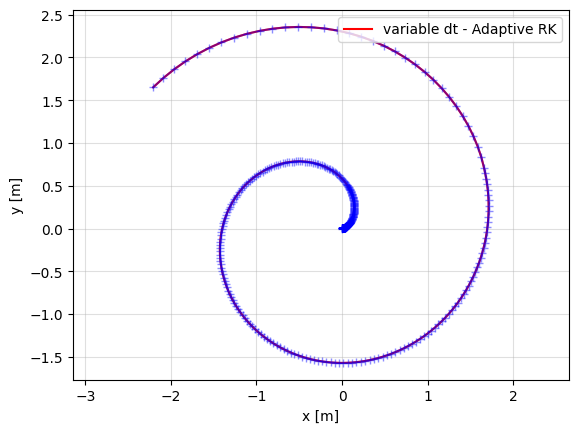

In [3]:
initial_state = jnp.array([0.0, 0.0, 0.0, 0.0])         # set initial state value
control = jnp.array([2.0, 1.0])                         # constant control over the 5 second duration. (u)  

tmax = 5                                                # specify duration for integration
controls = control                                      # constant control over the 5 second duration. (u)
initial_dt = 0.1                                        # initial time step value for starting integration

# Call adaptive RK 
xs_adaptRK = simulate(adaptive_runge_kutta_integrator,dynamic_unicycle_ode, step_compare, initial_state, controls, initial_dt,tmax)

# plot the trajectories
plt.plot(xs_adaptRK[:,0], xs_adaptRK[:,1], label="variable dt - Adaptive RK", color='r')
plt.plot(xs_adaptRK[:,0], xs_adaptRK[:,1], marker='+', color='b', alpha=0.45)
plt.legend()
    
plt.grid(alpha=0.4)
plt.axis("equal")
plt.xlabel("x [m]")
plt.ylabel("y [m]")

Plot: this plot is of the same variables, x and y position, as Problem 1 Part C of HW 1.
- the red line is the graph of the spiral created by the discrete time dynamics
- the blue cross markers are the individual plotted points generated by the discrete time dynamics to show their change in frequency

Observations:
It is easy to see the difference in density of plotted points increases as the curvature of the spiral becomes more intense. 

As the curvature of the spiral becomes more greater the time step (dt) decreases resulting in the ploints plotted closer together on the graph.

Thus, towardds the outside of the spiral the algorithm is more efficient, plotting less points (larger dt) but still capturing the behavior of the system, while towards the inside of the spiral the algortihm becomes less efficient (smaller dt) but captures more precise bahavior and small details as x and y change more in the same span of time.  